In [1]:
import ROOT, os, math, sys, glob
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import mplhep as hep
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.28/00


In [2]:
ROOT.gInterpreter.Declare("""
    using Vfloat = const ROOT::RVec<float>&;
    using Vint   = const ROOT::RVec<int>&;
    ROOT::RVec<int> find_bb_tautau(Vint GenPart_pdgId, Vint GenPart_genPartIdxMother, int pdgid_bb, int pdgid_tt) {
        bool Foundbjets = false;
        bool Foundtaus = false;
        int index_b1 = -1;
        int index_b2 = -1;
        int index_t1 = -1;
        int index_t2 = -1;
        for (int i_gen = 0; i_gen < GenPart_pdgId.size(); i_gen ++) {
            if (GenPart_genPartIdxMother.at(i_gen) == -1) continue; // it is the incoming parton
            if ((Foundbjets != true) && (fabs(GenPart_pdgId.at(i_gen)) == 5) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == pdgid_bb)) {
                if (index_b1 == -1) index_b1 = i_gen;
                else if (index_b2 == -1) index_b2 = i_gen;
                if ((index_b1 != -1) && (index_b2 != -1)) {
                    Foundbjets = true;
                }
            }
            if ((Foundtaus != true) && (fabs(GenPart_pdgId.at(i_gen)) == 15) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == pdgid_tt)) {
                if (index_t1 == -1) index_t1 = i_gen;
                else if (index_t2 == -1) index_t2 = i_gen;
                if ((index_t1 != -1) && (index_t2 != -1)) {
                    Foundtaus = true;
                }
            }
        }
        return {index_b1, index_b2, index_t1, index_t2} ;
    }
""")

True

In [3]:
ROOT.gInterpreter.Declare("""
    using Vfloat = const ROOT::RVec<float>&;
    using Vint   = const ROOT::RVec<int>&;
    bool check_gen_tag_matching(int index_1, int index_2, int bjet1_JetIdx, int bjet2_JetIdx,
            Vfloat GenPart_pt, Vfloat GenPart_eta, Vfloat GenPart_phi, Vfloat GenPart_mass,
            Vfloat Jet_pt, Vfloat Jet_eta, Vfloat Jet_phi, float deltaR) {
        bool matched = false;
        auto b1_gen_tlv = TLorentzVector();
        auto b2_gen_tlv = TLorentzVector();
        auto b1_tag_tlv = TLorentzVector();
        auto b2_tag_tlv = TLorentzVector();
        b1_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_1), GenPart_eta.at(index_1), GenPart_phi.at(index_1), GenPart_mass.at(index_1));
        b2_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_2), GenPart_eta.at(index_2), GenPart_phi.at(index_2), GenPart_mass.at(index_2));
        b1_tag_tlv.SetPtEtaPhiM(Jet_pt.at(bjet1_JetIdx), Jet_eta.at(bjet1_JetIdx), Jet_phi.at(bjet1_JetIdx), 0);
        b2_tag_tlv.SetPtEtaPhiM(Jet_pt.at(bjet2_JetIdx), Jet_eta.at(bjet2_JetIdx), Jet_phi.at(bjet2_JetIdx), 0);
        if (((b1_gen_tlv.DeltaR(b1_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b2_tag_tlv) < deltaR)) ||
            ((b1_gen_tlv.DeltaR(b2_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b1_tag_tlv) < deltaR))) {
            matched = true;
        }
        return matched;
    }
""")

True

In [4]:
def ComputeHHBTagPurity(folder, pdgid_tt, pdgid_bb, btag_wp):
    
    files = glob.glob(folder + '/*')
    dataframe_files = ROOT.vector(str)()
    for f in files:
        file = ROOT.TFile.Open(f)
        if file.Get("Events"):
            dataframe_files.push_back(f)
    df = ROOT.RDataFrame("Events", dataframe_files)

    df_res2b = df.Filter(f"(Jet_btagDeepFlavB.at(bjet1_JetIdx) > {btag_wp['medium']}) && \
                        (Jet_btagDeepFlavB.at(bjet2_JetIdx) > {btag_wp['medium']})")

    # find index for gen level b jets
    df_res2b = df_res2b.Define("index_b1", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(0)")
    df_res2b = df_res2b.Define("index_b2", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(1)")

    # check matching between tagged b jets and gen level b jets
    df_res2b = df_res2b.Define("matched", "check_gen_tag_matching(index_b1, index_b2, bjet1_JetIdx, bjet2_JetIdx,"
            "GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, Jet_pt, Jet_eta, Jet_phi, 0.4)")

    df_bb = df_res2b.Filter("(index_b1 != -1) && (index_b2 != -1)")
    df_matched = df_res2b.Filter("matched == 1")

    num = df_matched.Count().GetValue()
    den = df_bb.Count().GetValue()

    return [num/den, num/den * np.sqrt((np.sqrt(num)/num)**2+(np.sqrt(den)/den)**2)]


In [5]:
def SetStyle(x_label, y_label, x_lim = None, y_lim = None, leg_title=''):
    leg = plt.legend(loc = 'upper right', fontsize=20, title=leg_title, title_fontsize=18)
    leg._legend_box.align = "left"
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if x_lim: plt.xlim(x_lim)
    if y_lim: plt.ylim(y_lim)
    plt.grid()
    hep.cms.label(data=True, label="Private Work")

In [19]:
def PlotHHBTagPurity(v_mass, v_purity, v_purity_err, odir, process, fancy_name):
    fig = plt.figure(figsize=(10,10))
    cmap = plt.get_cmap('viridis')
    plt.errorbar(v_mass[0], v_purity[0], yerr=v_purity_err[0], lw=2, linestyle='', marker='o', color=cmap(0.6), label='SM')
    plt.errorbar(v_mass[1:], v_purity[1:], yerr=v_purity_err[1:], lw=2, linestyle='', marker='o', color=cmap(0), label='Resonant')
    SetStyle(x_label="Mass [GeV]", y_label="HHBTag purity", y_lim=(0.,1))
    plt.legend(loc='lower left', fontsize=20, title=fancy_name)
    plt.savefig(odir + f'/{process}_HHBTag_Purity.png')
    plt.savefig(odir + f'/{process}_HHBTag_Purity.pdf')

# Compute purity for HHBTag on ZZ samples (non-resonant and resonant)

In [22]:
indir = '/data_CMS/cms/vernazza/cmt/PreprocessRDF/'

mass_points = [ 200, 210, 220, 230, 240, 250, 260, 270, 280, 300, 320, 350, 360, 400, 450, 500, 550,
                600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                1800, 1900, 2000, 2200, 2400, 2500, 2600, 2800, 3000]
cfg = 'ul_201*_ZZ_v12'
ver = 'prod_240305'
sm_name = 'zz_sl_signal'
res_name = 'GluGluToXToZZTo2B2Tau'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZZbbtt'
fancy_name = r"$ZZ_{bb\tau\tau}$"
pdgid_bb = 23
pdgid_tt = 23

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{process}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_bb, pdgid_tt, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_bb, pdgid_tt, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

##########################################################################################

v_mass_zzbbtt = v_mass
v_purity_zzbbtt = v_purity
v_purity_err_zzbbtt = v_purity_err

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ZZbbtt/prod_240305


100%|██████████| 41/41 [01:45<00:00,  2.58s/it]


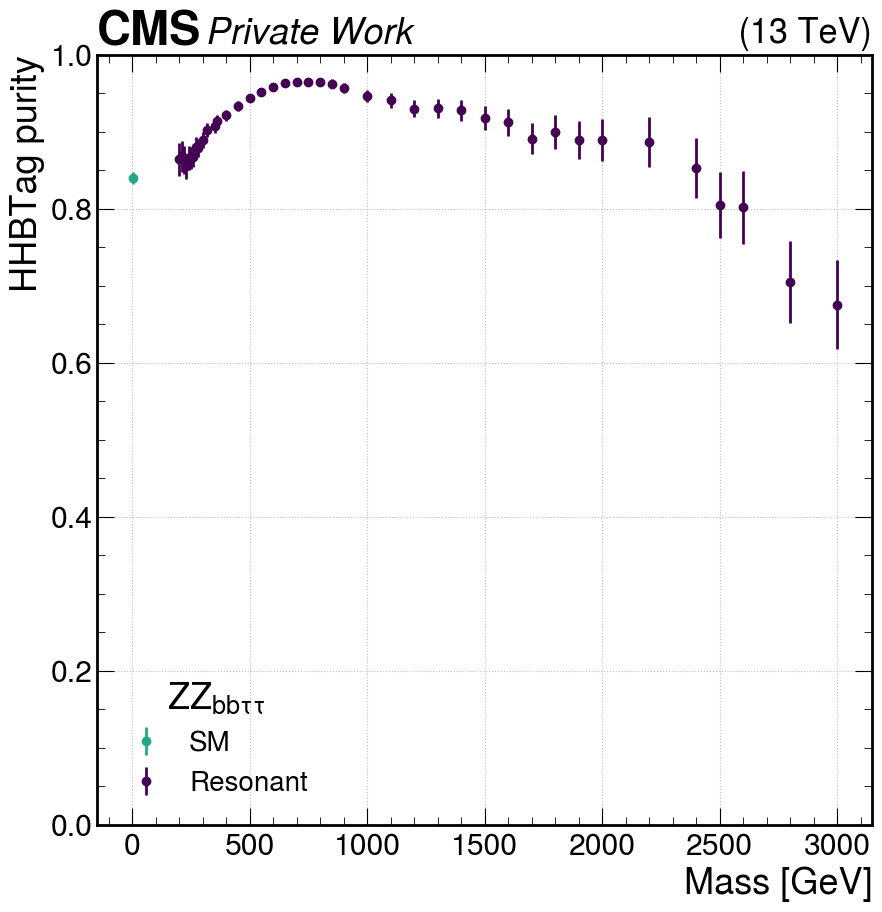

In [23]:
PlotHHBTagPurity(v_mass_zzbbtt, v_purity_zzbbtt, v_purity_err_zzbbtt, odir, process, fancy_name)

In [24]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8394914876217382
200 0.8638211382113821
210 0.8677966101694915
220 0.8629607004683364
230 0.8548193802431091
240 0.8656759906759907
250 0.865310198477094
260 0.8673391908016054
270 0.8803081884966851
280 0.8790119444218737
300 0.889049251307956
320 0.9015873015873016
350 0.9069696391063586
360 0.9135399673735726
400 0.9212991019778525
450 0.9331272539927872
500 0.9437283925754372
550 0.9513380954417783
600 0.9576694683570057
650 0.9628030991439093
700 0.963910077225565
750 0.9642821120580968
800 0.9650078875663273
850 0.9621790546539295
900 0.9561763776684569
1000 0.9462845149865547
1100 0.9404069090739793
1200 0.929909603039434
1300 0.930261313988954
1400 0.92756804214223
1500 0.9178450226244343
1600 0.911951973803893
1700 0.8904670197400096
1800 0.8993981083404987
1900 0.889134438305709
2000 0.8891276321443919
2200 0.8862199747155499
2400 0.8522072936660269
2500 0.8050632911392405
2600 0.8015267175572519
2800 0.704225352112676
3000 0.6754385964912281


# Compute purity for HHBTag on ZbbHtt samples (non-resonant and resonant)

In [25]:
indir = '/data_CMS/cms/cuisset/cmt/PreprocessRDF/'

mass_points = [600,800,1000,1200,1400,1600,1800,2000,2500,3000]
cfg = 'ul_201*_ZbbHtt_v12'
ver = 'prod_240305'
sm_name = 'zh_zbb_htt_signal'
res_name = 'ZprimeToZH_ZToBB_HToTauTau'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZbbHtt'
fancy_name = r"$Z_{bb}H_{\tau\tau}$"
pdgid_bb = 23
pdgid_tt = 25

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{process}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_tt, pdgid_bb, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_tt, pdgid_bb, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

##########################################################################################

v_mass_zbbhtt = v_mass
v_purity_zbbhtt = v_purity
v_purity_err_zbbhtt = v_purity_err

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ZbbHtt/prod_240305


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


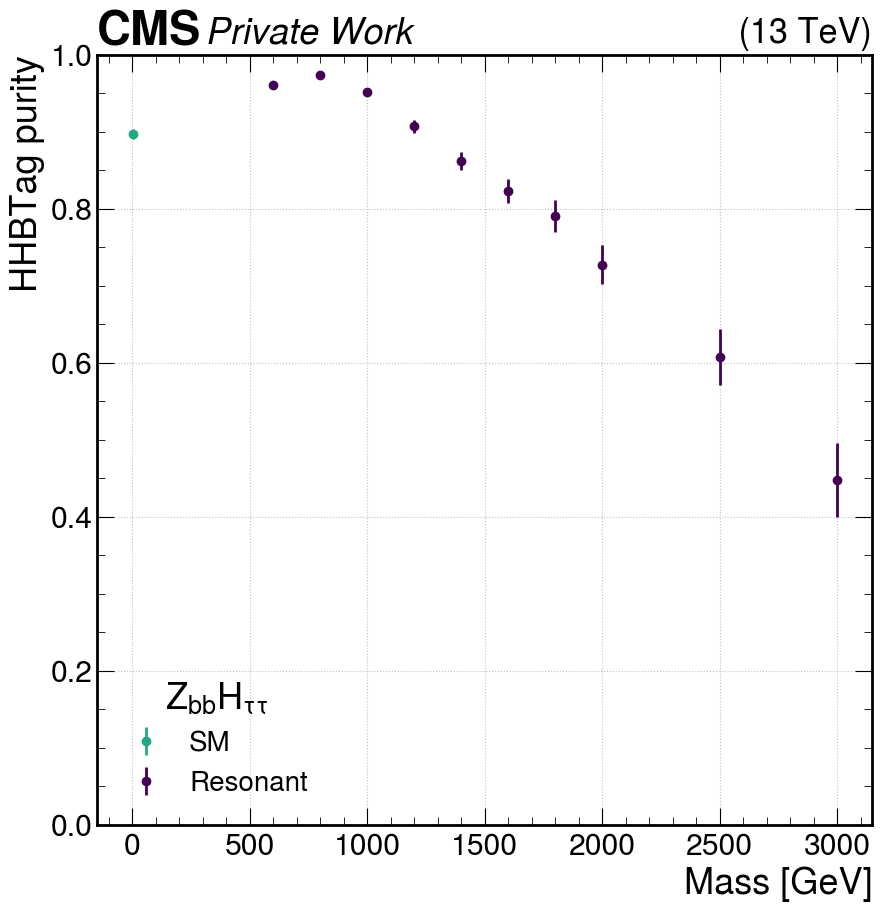

In [26]:
PlotHHBTagPurity(v_mass_zbbhtt, v_purity_zbbhtt, v_purity_err_zbbhtt, odir, process, fancy_name)

In [27]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8971303564534809
600 0.96096064797582
800 0.972979378999763
1000 0.95144969084626
1200 0.9069721273723497
1400 0.8616060329825143
1600 0.8231768231768232
1800 0.790341578327444
2000 0.7274081429990069
2500 0.607681755829904
3000 0.44755244755244755


# Compute purity for HHBTag on ZttHbb samples (non-resonant and resonant)

In [28]:
indir = '/data_CMS/cms/cuisset/cmt/PreprocessRDF/'

mass_points = [600,1000,1200,1400,1600,1800,2000,2500,3000]
cfg = 'ul_201*_ZttHbb_v12'
ver = 'prod_240305'
sm_name = 'zh_ztt_hbb_signal'
res_name = 'ZprimeToZH_ZToTauTau_HToBB'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZttHbb'
fancy_name = r"$Z_{\tau\tau}H_{bb}$"
pdgid_bb = 25
pdgid_tt = 23

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{process}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_tt, pdgid_bb, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_tt, pdgid_bb, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

##########################################################################################

v_mass_ztthbb = v_mass
v_purity_ztthbb = v_purity
v_purity_err_ztthbb = v_purity_err

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ZttHbb/prod_240305


100%|██████████| 9/9 [00:51<00:00,  5.73s/it]


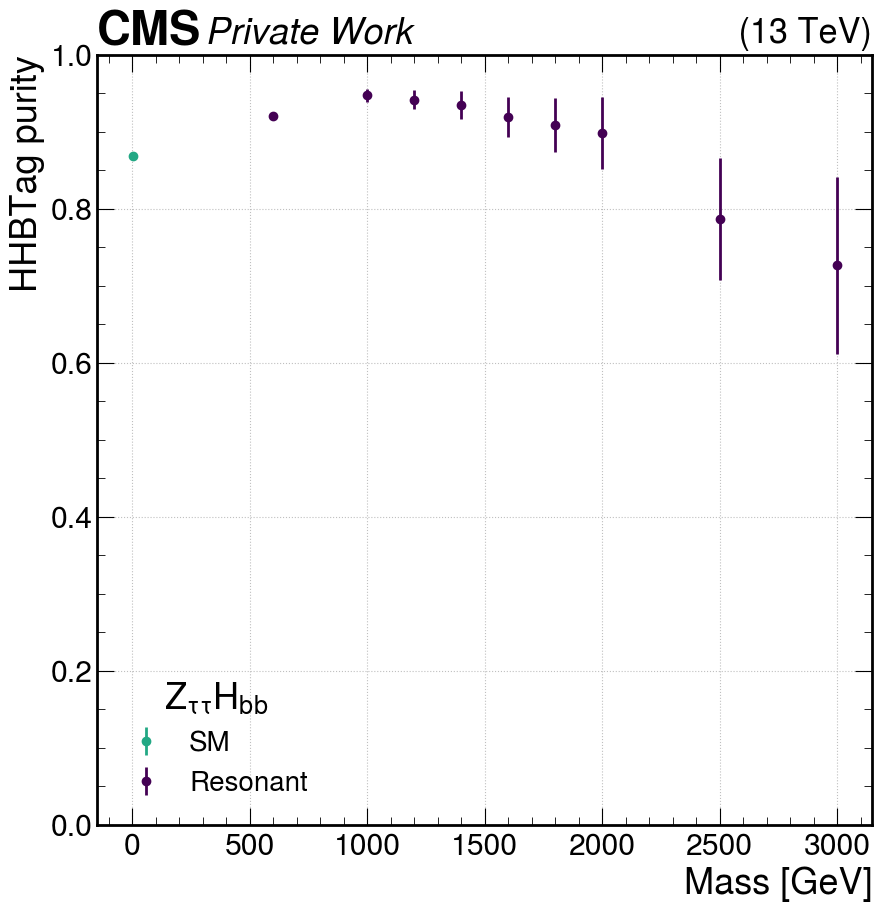

In [29]:
PlotHHBTagPurity(v_mass_ztthbb, v_purity_ztthbb, v_purity_err_ztthbb, odir, process, fancy_name)

In [30]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8682200773455526
600 0.9208983246678221
1000 0.9469166397299141
1200 0.9415557913639703
1400 0.9340239912758996
1600 0.9185606060606061
1800 0.9088339222614841
2000 0.8984575835475579
2500 0.7866666666666666
3000 0.7263157894736842


# Compare DeepJet and HHBtag

In [16]:
ROOT.gInterpreter.Declare("""
    using Vfloat = const ROOT::RVec<float>&;
    using Vint   = const ROOT::RVec<int>&;
    bool check_gen_tag_matching_btag(int index_1, int index_2, 
            Vfloat GenPart_pt, Vfloat GenPart_eta, Vfloat GenPart_phi, Vfloat GenPart_mass,
            Vfloat Jet_pt, Vfloat Jet_eta, Vfloat Jet_phi, Vfloat Jet_btagDeepFlavB, float deltaR) {
        bool matched = false;
        auto b1_gen_tlv = TLorentzVector();
        auto b2_gen_tlv = TLorentzVector();
        auto b1_tag_tlv = TLorentzVector();
        auto b2_tag_tlv = TLorentzVector();
        b1_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_1), GenPart_eta.at(index_1), GenPart_phi.at(index_1), GenPart_mass.at(index_1));
        b2_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_2), GenPart_eta.at(index_2), GenPart_phi.at(index_2), GenPart_mass.at(index_2));
        auto max_btagDeepFlavB_b1 = -1;
        auto max_btagDeepFlavB_b2 = -1;
        int index1 = -1;
        int index2 = -1;

        for (int i_jet = 0; i_jet < Jet_btagDeepFlavB.size(); i_jet ++) {
            if (Jet_btagDeepFlavB.at(i_jet) > max_btagDeepFlavB_b1) {
                max_btagDeepFlavB_b2 = max_btagDeepFlavB_b1;
                index2 = index1;
                max_btagDeepFlavB_b1 = Jet_btagDeepFlavB.at(i_jet);
                index1 = i_jet;
            } else if (Jet_btagDeepFlavB.at(i_jet) > max_btagDeepFlavB_b2) {
                max_btagDeepFlavB_b2 = Jet_btagDeepFlavB.at(i_jet);
                index2 = i_jet;
            }
        }
        b1_tag_tlv.SetPtEtaPhiM(Jet_pt.at(index1), Jet_eta.at(index1), Jet_phi.at(index1), 0);
        b2_tag_tlv.SetPtEtaPhiM(Jet_pt.at(index2), Jet_eta.at(index2), Jet_phi.at(index2), 0);
        if (((b1_gen_tlv.DeltaR(b1_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b2_tag_tlv) < deltaR)) ||
            ((b1_gen_tlv.DeltaR(b2_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b1_tag_tlv) < deltaR))) {
            matched = true;
        }
        return matched;
    }
""")

True

In [17]:
def ComputeDeepJetPurity(folder, pdgid_tt, pdgid_bb, btag_wp):
    
    files = glob.glob(folder + '/*')
    dataframe_files = ROOT.vector(str)()
    for f in files:
        file = ROOT.TFile.Open(f)
        if file.Get("Events"):
            dataframe_files.push_back(f)
    df = ROOT.RDataFrame("Events", dataframe_files)

    df_res2b = df.Filter(f"(Jet_btagDeepFlavB.at(bjet1_JetIdx) > {btag_wp['medium']}) && \
                        (Jet_btagDeepFlavB.at(bjet2_JetIdx) > {btag_wp['medium']})")

    # find index for gen level b jets
    df_res2b = df_res2b.Define("index_b1", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(0)")
    df_res2b = df_res2b.Define("index_b2", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(1)")

    # check matching between tagged b jets and gen level b jets
    df_res2b = df_res2b.Define("matched", "check_gen_tag_matching_btag(index_b1, index_b2,"
            "GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, Jet_pt, Jet_eta, Jet_phi, Jet_btagDeepFlavB, 0.4)")

    df_bb = df_res2b.Filter("(index_b1 != -1) && (index_b2 != -1)")
    df_matched = df_res2b.Filter("matched == 1")

    num = df_matched.Count().GetValue()
    den = df_bb.Count().GetValue()

    return [num/den, num/den * np.sqrt((np.sqrt(num)/num)**2+(np.sqrt(den)/den)**2)]

In [18]:
indir = '/data_CMS/cms/vernazza/cmt/PreprocessRDF/'

mass_points = [ 200, 210, 220, 230, 240, 250, 260, 270, 280, 300, 320, 350, 360, 400, 450, 500, 550,
                600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                1800, 1900, 2000, 2200, 2400, 2500, 2600, 2800, 3000]
cfg = 'ul_2018_ZZ_v12'
ver = 'prod_240305'
sm_name = 'zz_sl_signal'
res_name = 'GluGluToXToZZTo2B2Tau'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZZbbtt'
fancy_name = r"$ZZ_{bb\tau\tau}$"
pdgid_bb = 23
pdgid_tt = 23

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{cfg}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []
v_purity_dj = []
v_purity_err_dj = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_bb, pdgid_tt, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])
purity_dj = ComputeDeepJetPurity(sm_folder, pdgid_bb, pdgid_tt, btag_wp)
v_purity_dj.append(purity_dj[0])
v_purity_err_dj.append(purity_dj[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_bb, pdgid_tt, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])
    purity_dj = ComputeDeepJetPurity(mass_folder, pdgid_bb, pdgid_tt, btag_wp)
    v_purity_dj.append(purity_dj[0])
    v_purity_err_dj.append(purity_dj[1])

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ul_2018_ZZ_v12/prod_240305


  0%|          | 0/41 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10,10))
cmap = plt.get_cmap('viridis')
cmap_dj = plt.get_cmap('plasma')
plt.errorbar(v_mass[0], v_purity[0], yerr=v_purity_err[0], lw=2, linestyle='', marker='o', color=cmap(0.6), label='HHBTag SM')
plt.errorbar(v_mass[1:], v_purity[1:], yerr=v_purity_err[1:], lw=2, linestyle='', marker='o', color=cmap(0), label='HHBTag Resonant')
plt.errorbar(v_mass[0], v_purity_dj[0], yerr=v_purity_err_dj[0], lw=2, linestyle='', marker='o', color=cmap(0.2), label='DeepJet SM')
plt.errorbar(v_mass[1:], v_purity_dj[1:], yerr=v_purity_err_dj[1:], lw=2, linestyle='', marker='o', color=cmap(0.4), label='DeepJet Resonant')
SetStyle(x_label="Mass [GeV]", y_label="Purity", y_lim=0.)
plt.legend(loc='upper right', fontsize=20, title=fancy_name)
# plt.savefig(odir + f'/{process}_HHBTag_Purity.png')
# plt.savefig(odir + f'/{process}_HHBTag_Purity.pdf')

Error in callback <function flush_figures at 0x7f9d8d4a5580> (for post_execute):


KeyboardInterrupt: 